# Determining tracing flows in critical epidemics
Nils Bruin and Alexa van der Waall, April 29

This code is instrumented to keep track of the flow of infected to quarantine due to contact tracing. This is a measure for how much contact tracing is contributing to maintaining a sufficient outflow to prevent the epidemic to move into supercritical, exponential growth.

The parameter we control here for contact tracing is called $\tau$ here. It's really the proportion of infections that is identified by tracing at each tracing step (so, it's the pruning factor on the infection tree).

Very rough take-aways: with a disease below that has an R0 a little above 2 (but this is depressed because we're not letting up distancing entirely) and an active case level of about 2000 (with a 20 day disease length), we see that about 40 successful trace-based identifications per day are required. Since this pushes the R0 from 2 to 1 (that's what we're trying to do), this results, on average, in reducing the infections caused by a person from 2 to 1: that means that these 40 successes due to tracing are likely due to *distinct traces*. The effort of tracing required for this will depend on the ratio of the infecting contacts to the total number of contacts per time unit per person.

Another point in this disease: because its infection starts so early, and people only quarantine a while after they develop symptoms, we basically have a disease with very late self-quarantining (and detection!). So by the time we detect someone, their infections are already busy infecting -- in fact they're almost done infecting! So tracing only becomes effective in the second degree: you have to work quite hard on these traces. An app-based tracer would need knock-on, because this disease profile would largely escape depth-1 contact tracing. This last bit is just logical reasoning and looking at the distributions. The code here is currently not written to simulate limited-depth contact tracing, but that would be fairly straightforward to change.

In [1]:
import numpy as np
from numpy import exp, abs, log, floor,sqrt
import matplotlib.pyplot as plt
from scipy.integrate import quad
from functools import reduce
from operator import mul
def prod(L): return reduce(mul,L)

#I need a function with compact support, and choosing a differentiable seemed nice
#this is the simplest I could think of; it is not otherwise motivated for the
#distributions that I need it for.
def compact_support_function(min=0,max=1,shape=1,skew=1,scale=1):
    """Returns an infinitely differentiable function with compact support
    
    Returns an appropriate transform of exp(1/(x(x-1))).
    Parameters:
      [min,max] : interval on which function is non-zero
      shape     : (>0) larger values make the peak sharper
      skew      : (>0) Values <1 mean skew to left, values >1 mean skew to right
      scale     : maximum value.
    """
    interval_length=max-min
    scale=scale/exp(-4*shape)
    def f(x):
        t=(x-min)/interval_length
        if 0<t<1:
            ts=t**skew
            return scale*exp(shape/ts/(ts-1))
        else:
            return 0
    return f

class simulation:
    def __init__(self,N,beta_dist,q_dist,I0,policy,S0=1.0,time_scale=1.0):
        
        #conversion between real time and discrete time step number
        self.N = N
        Tfactor = N/time_scale
        self.Tfactor = Tfactor
        
        #discretize distributions
        beta=[quad(beta_dist,i/Tfactor,(i+1)/Tfactor)[0] for i in range(N)]
        symptom_onset_prop=[quad(q_dist,i/Tfactor,(i+1)/Tfactor)[0] for i in range(N)]
        q=[]
        symptomatic_prop=[]
        running_total=0
        for i in range(N):
            q.append(symptom_onset_prop[i]/(1-running_total))
            running_total+=symptom_onset_prop[i]
            symptomatic_prop.append(running_total)
        
        #sanity check that conditional probabilities match total
        assert abs((1-sum(symptom_onset_prop)-prod((1-c) for c in q)))< 10e-5
        
        #bookkeeping
        self.beta_dist=beta_dist
        self.q_dist=q_dist
        self.beta=beta
        self.symptom_onset_prop=symptom_onset_prop
        self.symptomatic_prop=symptomatic_prop
        self.q=q
        self._s=[]
        self._r=[]
        self._I=[]
        self._Q=[]
        self._traced=[]
        self._newly_infected=[]
        self._quartested=[]
        self._betaprime=[]
        self.I0=I0
        self.S0=S0
        self.N=N
        self.policy=policy
        self._policy=[]
        self.time_scale=time_scale

        
    #conversion function between real time and step number (t is real time; T is step number)
    def T_from_t(self,t):
        return int(floor(t*self.Tfactor))
    def t_from_T(self,T):
        return T/self.Tfactor
    def time_step_list(self,t0,t1):
        return np.arange(t0,t1,1/self.Tfactor)
        
    #access functions: our initial conditions are, for T<0, a proportion I0 of the
    #population uniformly distributed over the I_a, with no quarantining or infections happening.
    def s(self,T):
        return self._s[T] if T>=0 else self.S0-self.I0
    def r(self,T):
        return self._r[T] if T>=0 else 1-self.S0
    def I(self,T):
        return self._I[T] if T>=0 else tuple(self.I0/self.N for i in range(self.N))
    def Q(self,T):
        return self._Q[T] if T>=0 else tuple(0 for i in range(self.N))
    def betaprime(self,T):
        return self._betaprime[T] if T>=0 else tuple(0 for i in range(self.N))
    
    #this is the actual step. It computes step T+1 from step T. It's an internal routine.
    def step_after(self,T):
        N=self.N
        
        #we should only get called if T+1 is really the next step to be computed.
        if len(self._s) != T+1:
            raise RuntimeError("length mismatch")
        policyT=self.policy(self,self.t_from_T(T))
        self._policy.append(policyT)
        C_quar,C_contact,C_test,C_trace=policyT
        Ctst=C_test/self.Tfactor
        s=self.s(T)
        r=self.r(T)
        betaprime=[s*self.beta[i]*C_contact for i in range(self.N)]
        IT=self.I(T)
        QT=self.Q(T)
        Inew=sum([d*i for d,i in zip(betaprime,IT)])
        Qnew=[(C_quar*c+Ctst)*i for c,i in zip(self.q,IT)]
        quartested=sum(Qnew)
        
        #this is the loop where we compute the quarantining contribution
        #of contact tracing: we work from the oldest infections forward,
        #so that we can take into account the derived infections from
        #the ones added earlier in the loop.
        traced=0
        for dT in range(self.N-1,-1,-1):
            traced_dT = 0
            for age in range(dT,self.N):
                traced_dT+=self.betaprime(T-dT)[age-dT]*Qnew[age]*C_trace
            Qnew[dT]+=traced_dT
            traced+=traced_dT
        IT=[i-q for i,q in zip(IT,Qnew)]
        QT=[v+q for v,q in zip(QT,Qnew)]
        s-=Inew
        r+=IT[-1]+QT[-1]
        self._s.append(s)
        self._r.append(r)
        self._I.append([Inew]+IT[:-1])
        self._Q.append([0]+QT[:-1])
        self._traced.append(traced)
        self._newly_infected.append(Inew)
        self._quartested.append(quartested)
        self._betaprime.append(betaprime)
        
    def compute(self,t):
        """Ensures that the simulation is computed to time t (i.e., t*N steps)
        """
        Tend=self.T_from_t(t)
        for T in range(len(self._s)-1,Tend):
            self.step_after(T)

    def estimate_R0(self,n=10):
        """Approximate R0 using bisection
        """
        N=self.N
        A=2*N
        B=2*A
        time_span=self.t_from_T(B)
        mx=1
        mn=0
        for j in range(10):
            mid=(mx+mn)/2
            S=simulation(N,self.beta_dist,self.q_dist,I0=0.00001,S0=mid,policy=self.policy,time_scale=self.time_scale)
            S.compute(time_span)
            v=[sum(i)+sum(q) for i,q in  zip(S._I[A:B],S._Q[A:B])]
            R_est = sum([v[i+1]/v[i] for i in range(len(v)-1)])/(len(v)-1)
            if R_est < 1:
                mn = mid
            else:
                mx = mid
        Sstable=mid
        R0=1/Sstable
        return R0

    def disease_plots(self):
        """produces plots illustrating the characteristics of the configured disease
        """
        N=self.N
        Tfactor=self.Tfactor
        stride=1/Tfactor
        time_scale=self.time_scale
        t_range=np.arange(0,time_scale,time_scale/100)

        fig, ((ax1,ax4),(ax2,ax3)) = plt.subplots(2,2)
        ax4.get_shared_y_axes().join(ax1, ax4)
        fig.set_size_inches(16,10)
        fvals=[self.beta_dist(a) for a in t_range]
        ticks=np.arange(stride/2,time_scale,stride)
        R0=sum(self.beta)
        ax1.bar(ticks,[i*Tfactor for i in self.beta],alpha=0.5,width=stride,label="infectivity integrated\n over intervals")
        ax1.plot(t_range,fvals,color="black",label="infectivity density")
        ax1.set_title("Infectivity (area=R0)")
        ax1.set_xlabel("infection age")
        ax1.set_ylabel("infection rate")
        R0_label_y=max(fvals)/10
        R0_label_x=time_scale/10
        ax1.text(R0_label_x,R0_label_y,"R0 = {:3.3}".format(R0))
        ax1.legend(loc="upper right")

        fvals=[self.q_dist(a) for a in t_range]
        ax2.plot(t_range,fvals,color="black",label="density")
        ax2.bar(ticks,[i*Tfactor for i in self.symptom_onset_prop],alpha=0.5,width=stride,label="integrated")
        ax2.bar(ticks,[i*Tfactor for i in self.q],alpha=0.2,color="red",width=stride,label="conditional rates")
        ax2.set_title("Symptom distribution")
        ax2.legend()
        ax2.set_xlabel("infection age")
        ax2.set_ylabel("symptom rate")

        ax3.set_title("asymptomatic infected proportion")
        ax3.set_xlabel("infection age")
        ax3.set_ylabel("asymptomatic proportion")
        ax3.text(R0_label_x,0.1,"asymptomatic proportion = {:3.3}".format(1-self.symptomatic_prop[-1]))
        ax3.bar(ticks,[1-p for p in self.symptomatic_prop],alpha=0.5,width=stride)

        q_adjusted_infection_coefficient=[(1-p)*c for p,c in zip(self.symptomatic_prop,self.beta)]
        R0q=sum(q_adjusted_infection_coefficient)
        ax4.set_title("Quarantine-adjusted infectivity (area=R0q)")
        ax4.set_xlabel("infection age")
        ax4.set_ylabel("infection rate")
        ax4.text(R0_label_x,R0_label_y,"R0q = {:3.3}".format(R0q))
        ax4.bar(ticks,[c*Tfactor for c in q_adjusted_infection_coefficient],alpha=0.5,width=stride)
        return fig
        
    def time_plots(self,t):
        """Produces time series plots that show the simulation for time (0...t)
        """
        self.compute(t)
        T=int(t*self.N/self.time_scale)
        s=self._s[:T]
        r=self._r[:T]
        I=self._I[:T]
        Q=self._Q[:T]
        traced=[c*self.N/self.time_scale for c in self._traced[:T]]
        fig, (ax2,ax1,ax3) = plt.subplots(1,3)
        fig.set_size_inches(16,5)
        times=[a/self.N*self.time_scale for a in range(T)]
        ax1.set_title("active cases")
        ax1.set_xlabel("time")
        ax1.set_ylabel("proportion of population")
        ax1.plot(times,[sum(i) for i in I],label="infected unquarantined")
        ax1.plot(times,[sum(i)+sum(q) for i,q in zip(I,Q)],label="total active")
        ax1.plot(times,[sum(i) for i in Q],label="quarantined")
        ax1.plot(times,traced,label="traced")
        ax1.legend(loc="upper right")
        ax2.set_title("susceptible/removed")
        ax2.set_xlabel("time")
        ax2.set_ylabel("proportion of population")
        ax2.plot(times,s,label="susceptible")
        ax2.plot(times,[sum(i)+sum(q) for i,q in zip(I,Q)],label="total active")
        ax2.plot(times,r,label="removed")
        ax2.legend()
        ax2.set_ylim([0,1])
        ax3.set_title("policy")
        ax3.set_ylim([0,1.01])
        ax3.set_xlabel("time")
        ax3.set_ylabel("measure intensity")
        policy=self._policy[:T]        
        ax3.plot(times,[a[0] for a in policy],label="self-quarantining")
        ax3.plot(times,[1-a[1] for a in policy],label="physical distancing")
        ax3.plot(times,[a[2] for a in policy], label="surveilance testing")
        ax3.plot(times,[a[3] for a in policy],label="contact tracing")
        ax3.legend()
        return fig

    def traced_plot(self,t):
        self.compute(t)
        T=int(t*self.N/self.time_scale)
        traced=[c*self.N/self.time_scale for c in self._traced[:T]]
        newly_infected=[c*self.N/self.time_scale for c in self._newly_infected[:T]]
        quartested=[c*self.N/self.time_scale for c in self._quartested[:T]]
        fig, ax1 = plt.subplots()
        times=[a/self.N*self.time_scale for a in range(T)]
        ax1.set_title("traced cases per time unit")
        ax1.set_xlabel("time")
        ax1.set_ylabel("proportion of population")
        ax1.plot(times,traced,label="traced")
        ax1.plot(times,quartested,label="self-isolated and tested")
        ax1.plot(times,newly_infected,label="newly infected")        
        ax1.legend(loc="upper right")
        return fig

        
#this routine computes tau (proportion of feasible contact tracing) required to get R0=0
#in a straightforward SAIR model.

def compute_tau(alpha,beta0,gamma_i,gamma_a,kappa_q, Cd, Cq, Cs):
    kappaI = Cq*kappa_q+Cs
    u = kappaI + (1-Cq)*gamma_i
    kappaA = Cs
    v = kappaA + gamma_a
    w = u-v
    beta1=beta0*(1-Cd)
    R0=(2*beta1/(beta1+u+v-sqrt(beta1**2-4*(alpha-1/2)*beta1*(u-v)+(u-v)**2)))
    Ct=1-1/R0
    beta=beta1*(1-Ct)
    L=(1/(2*w)*(beta+w-sqrt(w**2-4*(alpha-1/2)*beta*w+beta**2)))
    tau= Ct/(kappaI/u * L + kappaA/v *(1-L))
    tau_alpha = Ct/(kappaI/u * alpha + kappaA/v *(1-alpha))
    return tau,tau_alpha,L

## Basic distribution shape
we build a distribution with mean about 6 and variance about 4.2. Perhaps we should have a distribution with a heavier tail?

0.9999998191122534 6.055960652982012 4.220949967279045


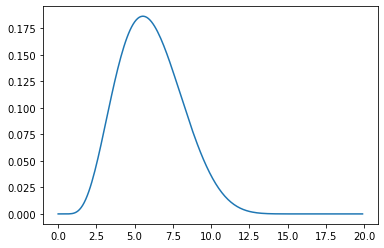

In [2]:
f=compact_support_function(0,20,shape=2.5,skew=0.54,scale=1/5.369727)
xr=np.arange(0,20,0.1)
fig,ax=plt.subplots()
ax.plot(xr,[f(x) for x in xr])
m0=quad(f,0,20)[0]
mean=quad(lambda x: x*f(x),0,20)[0]/m0
variance=quad(lambda x: (x-mean)**2*f(x),0,20)[0]/m0
print(m0,mean,variance)

## Disease profile
The shape of the distribution above is what we use for "symptom onset". We shift infectivity forward by 1 day.
What is called "symptom onset" in the model is really "go in self-isolation", so if people go into self-isolation 5 days after symptom onset, we need to shift it back by 5 days. We also set a symptom onset proportion of $\alpha=0.8$, so about 20% is asymptomatic.

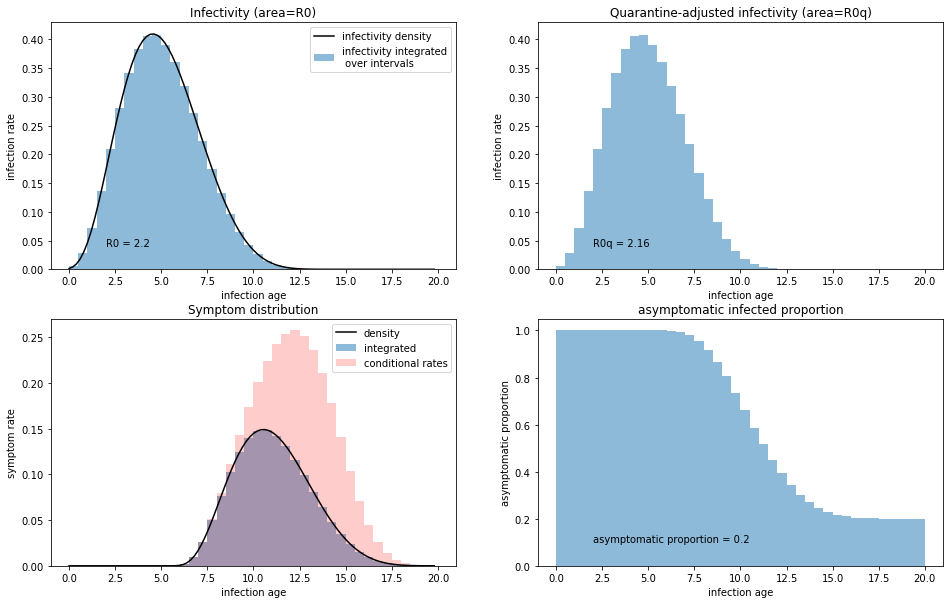

In [3]:
alpha=0.8
beta_dist=lambda t: 2.2*f(t+1)
q_dist=lambda t: alpha*f(t-5)
N=40
time_scale=20
#prevalence
POP=5.1e6
I0=2000/POP
S=simulation(N,beta_dist,q_dist,I0,policy=lambda S,t:(1,1,0,0),time_scale=time_scale)
_=S.disease_plots()

First let's consider just distancing. With $R_0=2.17$ (assuming quarantining), we see we should limit contact to $1-1/R_0\sim 1-0.54$ of the normal contact

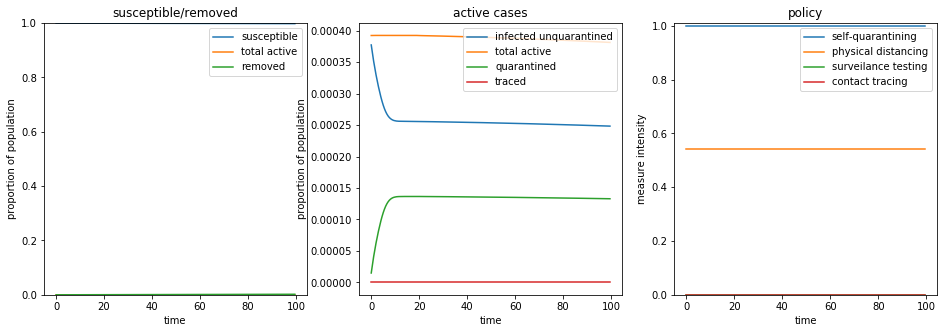

In [4]:
S=simulation(40,beta_dist,q_dist,I0,policy=lambda S,t:(1,1-0.54,0,0),time_scale=20)
_=S.time_plots(100)

We look at $R_0$ as a function of the contact tracing intensity. Since our quarantining (and hence our detection) happens quite a bit after becoming infective, we expect that tracing to the second level has quite a significant effect. Indeed, with these rather extreme distributions, we see the shape bent quite a bit.

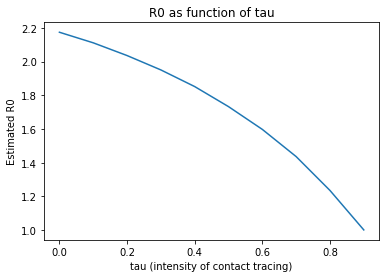

In [5]:
tau_range=np.arange(0,1,0.1)
R0_range=[]
for tau in tau_range:
    S=simulation(N,beta_dist,q_dist,0.001,policy=lambda S,t:(1,1,0,tau),time_scale=time_scale)
    R0_range.append(S.estimate_R0())
fig,ax=plt.subplots()
ax.plot(tau_range,R0_range)
ax.set_title("R0 as function of tau")
ax.set_xlabel("tau (intensity of contact tracing)")
_=ax.set_ylabel("Estimated R0")

So, let's halve our distancing and see how much tracing we have to do.

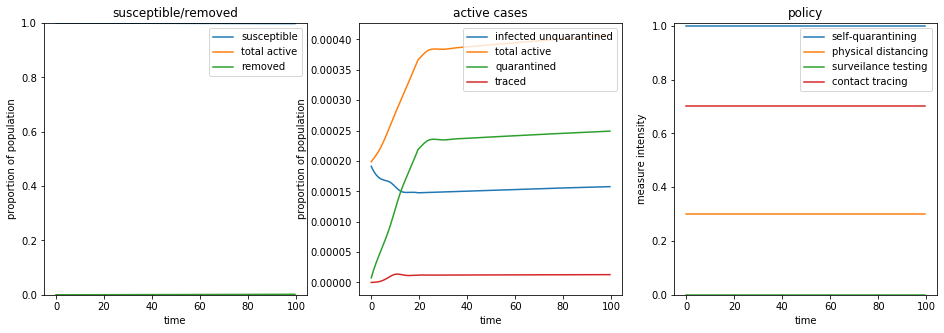

In [6]:
S=simulation(40,beta_dist,q_dist,I0/2,policy=lambda S,t:(1,1-0.3,0,0.70),time_scale=20)
_=S.time_plots(100)

Let's see how many get traced per time unit. We're keeping track of how many infected people get transferred into quarantine due to contact tracing. In practice, you'd have to contact trace more people, because there are also contacts that were not infected. Note that our initial conditions have no-one in quarantine, so the system needs some time to even this out. We precompensate by starting with a lower number of infected, so that levels stabilize where we want them. We see that we need to identify about 1.5% of the infected population per day by contact tracing.

Total active cases a little further out in time: 2075.3702593009075
People traced per day: 32.78694407470708
People traced per day as proportion of infected population: 0.015798117915475685


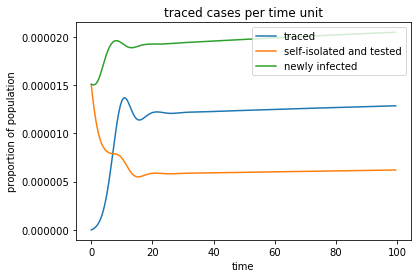

In [7]:
_=S.traced_plot(100)
infected_pop=(sum(S._Q[-1])+sum(S._I[-1]))
print("Total active cases a little further out in time: {}".format(POP*infected_pop))
print("People traced per day: {}".format(S._traced[-1]*POP))
print("People traced per day as proportion of infected population: {}".format(S._traced[-1]/infected_pop))

Let's halve the distancing measures once again. We see we have to increase tracing intensity even further.

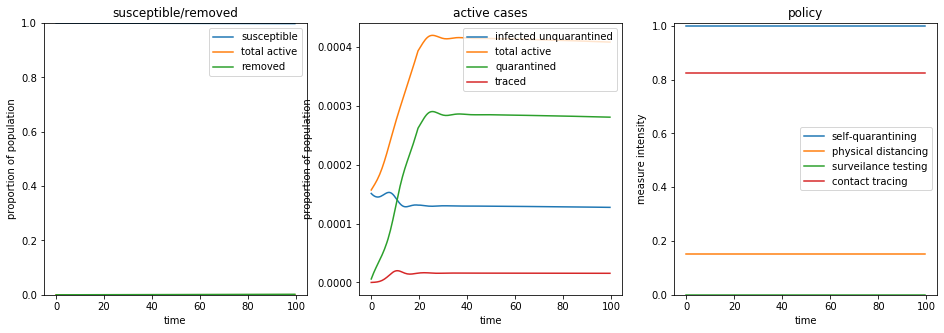

In [8]:
S=simulation(40,beta_dist,q_dist,I0/2.55,policy=lambda S,t:(1,1-0.15,0,0.825),time_scale=20)
_=S.time_plots(100)

Relaxation takes a little more still. With more intense tracing we obviously need to identify more people: now it's about 1.9% of the infected population per day that we need to identify by tracing.

Total active cases a little further out in time: 2083.060174975907
People traced per day: 39.65382539270435
People traced per day as proportion of infected population: 0.01903633215644526


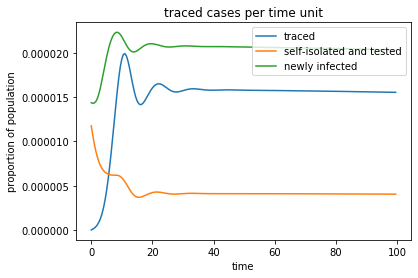

In [9]:
_=S.traced_plot(100)
infected_pop=(sum(S._Q[-1])+sum(S._I[-1]))
print("Total active cases a little further out in time: {}".format(POP*infected_pop))
print("People traced per day: {}".format(S._traced[-1]*POP))
print("People traced per day as proportion of infected population: {}".format(S._traced[-1]/infected_pop))